In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf

MACD strategy: go long when the signal (EMA of the MACD) crosses above the MACD, go short when it crosses below.

## Retrieve data

In [2]:
symbols=pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0].Symbol

In [3]:
sym=symbols[1]

In [4]:
start='2020-11-01'
end='2023-01-01'
data=yf.Ticker('TSLA').history(start=start,end=end).Close
data.index=data.index.date

## Function definition

In [5]:
def macd(data, win_fast, win_slow, win_signal, plot=False, verbose=False):

    df=pd.DataFrame(data.rename('close'))
    df['ewm_fast']=data.ewm(span=win_fast).mean()
    df['ewm_slow']=data.ewm(span=win_slow).mean()
    df['macd']    =df.ewm_fast-df.ewm_slow
    df['macd_signal']  =df.macd.ewm(span=win_signal).mean()
    df['osc']     = df.macd-df.macd_signal

    df['trade']=np.where(df.macd>df.macd_signal, 1, -1)
    df['returns']=np.log(df.close/df.close.shift(1))
    df['strategy']=df.returns * df.trade.shift(1)

    cumulat_hold_ret= np.exp(df.returns.cumsum())
    cumulat_strat_ret=np.exp(df.strategy.cumsum())

    if verbose==True:
        print('{:20}{}'.format('Stock return: ',cumulat_hold_ret[-1].round(3) ))
        print('{:20}{}'.format('Strategy return: ',cumulat_strat_ret[-1].round(3) ))

    if plot==True:
        fig,(ax0,ax1,ax2)=plt.subplots(nrows=3,figsize=(9,5))

        ax0.plot(cumulat_hold_ret, label='Stock')
        ax0.plot(cumulat_strat_ret, label='Strategy')
        ax0.legend(fontsize=8,loc=2)

        ax0.set_xmargin(0)
        ax1.set_xmargin(0)
        ax2.set_xmargin(0)
        df[['close','ewm_fast','ewm_slow']].plot(ax=ax1)
        #plt.legend(fontsize=8)

        df[['macd','macd_signal']].plot(ax=ax2)
        ax2.bar(df.index,df['osc'],color='purple',width=4)
        plt.legend(fontsize=8)
        
    return cumulat_hold_ret, cumulat_strat_ret

Let's try the function with the standard parameters used for this strategy.

Stock return:       0.923
Strategy return:    2.008


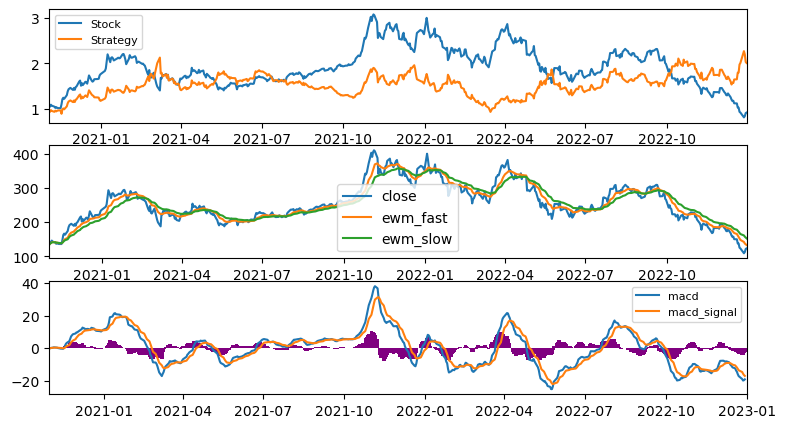

In [6]:
win_fast=12
win_slow=26
win_signal=9

x=macd(data, win_fast, win_slow, win_signal,plot=True,verbose=True);

## Testing the strategy

Let's define a function to split the data sequentially into a train set and a test set (e.g. the first 80% and last 20% respectively of the time series), and another function to test the strategy on different parameter combinations, sorting them by efficiency on the train set.

In [7]:
def train_test_series(data, pct):
    train_size=int(pct*len(data))
    train_data=data.iloc[:train_size]
    test_data =data.iloc[train_size:]
    return train_data, test_data

In [8]:
def model_tuning(data, parameter_arrays):
    holds=[]
    strats=[]
    ratios=[]
    for p in parameter_arrays:
        
        hold =  macd(data, p[0],p[1],p[2])[0][-1];
        strat = macd(data, p[0],p[1],p[2])[1][-1];
        ratio = strat/hold
        
        holds.append(hold)
        strats.append(strat)
        ratios.append(ratio)
    df=pd.DataFrame({'params':[str(p) for p in parameter_arrays], 'hold_ret':holds ,'strat_ret':strats,'ratio':ratios})
    df=df.sort_values(by=['ratio','strat_ret','hold_ret','params'],ascending=False)
    return df

In [9]:
#Define the parameter arrays to try out.

range_fast=range(1,10,2)
range_slow=range(14,30,3)
ema_signal=range(5,15,2)

params=[(a,b,c) for a in range_fast for b in range_slow for c in ema_signal]

In [10]:
#Split the data into a train set and a test set.

train_data,test_data=train_test_series(data,0.8)

In [11]:
model_tuning(train_data,params)

,params,hold_ret,strat_ret,ratio
96,"(7, 17, 7)",2.058526,3.051364,1.482306
91,"(7, 14, 7)",2.058526,3.025969,1.469969
63,"(5, 14, 11)",2.058526,2.958636,1.437260
125,"(9, 17, 5)",2.058526,2.927549,1.422158
67,"(5, 17, 9)",2.058526,2.927549,1.422158
...,...,...,...,...
5,"(1, 17, 5)",2.058526,0.429473,0.208631
0,"(1, 14, 5)",2.058526,0.425927,0.206909
1,"(1, 14, 7)",2.058526,0.417972,0.203044
10,"(1, 20, 5)",2.058526,0.405036,0.196760


Stock return:       0.439
Strategy return:    1.418


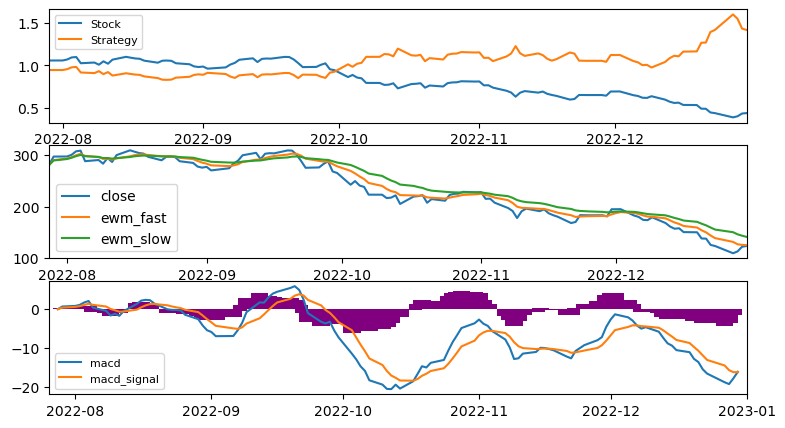

In [12]:
#Test if the strategy is still profitable with the optimal training parameters.
macd(test_data,7,17,7,plot=True, verbose=True);